# Ben's version of creating charts for the New AutoMotive index

We want three main charts:
- Miles driven by ICEs (or all cars)
- Miles driven by BEVs
- Selective chart with make/model


In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from pandas_ods_reader import read_ods
import re

## 1. Ice mileage over time

Start with total cars on the road

In [20]:
file_url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/942370/veh0120.ods'
df = pd.read_excel(file_url, 'Cars', engine='odf')
headers = df.iloc[5]
df = df.iloc[6:]
df.columns = headers

In [21]:
#clean up tail of df
# df.drop()

In [58]:
# df.head()

In [31]:
# df.tail()

In [32]:
# df.isna().sum()

In [25]:
# How many cars on the road?
print(f"Cars on the road: {df['2020 Q3 UK'].sum() / 1_000_000}m")
print(f"Total Teslas: {df[df['Make'] == 'TESLA']['2020 Q3 UK'].sum()}")
print(f"Teslas sold in 2020: {df[df['Make'] == 'TESLA']['2020 Q3 UK'].sum() - df[df['Make'] == 'TESLA']['2019 Q4 UK'].sum()}")

Cars on the road: 32.869865m
Total Teslas: 41314
Teslas sold in 2020: 16423


In [41]:
df_GB = df[['Make', 'Model 1', '2020 Q3 GB', '2020 Q2 GB', '2020 Q1 GB',
       '2019 Q4 GB', '2019 Q3 GB', '2019 Q2 GB', '2019 Q1 GB', '2018 Q4 GB',
       '2018 Q3 GB', '2018 Q2 GB', '2018 Q1 GB', '2017 Q4 GB', '2017 Q3 GB',
       '2017 Q2 GB', '2017 Q1 GB', '2016 Q4 GB', '2016 Q3 GB', '2016 Q2 GB',
       '2016 Q1 GB', '2015 Q4 GB', '2015 Q3 GB', '2015 Q2 GB', '2015 Q1 GB',
       '2014 Q4 GB', '2014 Q3 GB', '2014 Q2', '2014 Q1', '2013 Q4', '2013 Q3',
       '2013 Q2', '2013 Q1', '2012 Q4', '2012 Q3', '2012 Q2', '2012 Q1',
       '2011 Q4', '2011 Q3', '2011 Q2', '2011 Q1', '2010 Q4', '2010 Q3',
       '2010 Q2', '2010 Q1', '2009 Q4', '2009 Q3', '2009 Q2', '2009 Q1',
       '2008 Q4', '2008 Q3']]

df_UK = df[['Make', 'Model 1', '2020 Q3 UK', '2020 Q2 UK', '2020 Q1 UK',
       '2019 Q4 UK', '2019 Q3 UK', '2019 Q2 UK', '2019 Q1 UK', '2018 Q4 UK',
       '2018 Q3 UK', '2018 Q2 UK', '2018 Q1 UK', '2017 Q4 UK', '2017 Q3 UK',
       '2017 Q2 UK', '2017 Q1 UK', '2016 Q4 UK', '2016 Q3 UK', '2016 Q2 UK',
       '2016 Q1 UK', '2015 Q4 UK', '2015 Q3 UK', '2015 Q2 UK', '2015 Q1 UK',
       '2014 Q4 UK', '2014 Q3 UK']]

Instead of column names, we'll replace them with a date series that we'll create, quarterly.

In [42]:
df_GB.head()

5,Make,Model 1,2020 Q3 GB,2020 Q2 GB,2020 Q1 GB,2019 Q4 GB,2019 Q3 GB,2019 Q2 GB,2019 Q1 GB,2018 Q4 GB,...,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4,2009 Q3,2009 Q2,2009 Q1,2008 Q4,2008 Q3
6,ABARTH,124 GT MULTIAIR,18,18,18,18,18,18,17,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ABARTH,124 GT MULTIAIR AUTO,28,27,26,26,28,28,24,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ABARTH,124 SPIDER MULTIAIR,1000,995,970,998,1039,1044,1033,996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ABARTH,124 SPIDER MULTIAIR AUTO,634,674,673,682,693,681,660,468,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,ABARTH,124 SPIDER SCORPIONE MULTIAIR,63,57,45,40,58,63,65,61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
total_cars = df_GB.sum()
total_cars = pd.DataFrame(total_cars).reset_index()
total_cars.columns = ['date', 'cars']
total_cars.drop(['date'], axis=1, inplace=True)
total_cars['date'] = pd.date_range(start='2008-09-30', end='2020-09-30', freq='Q')[::-1]
total_cars = total_cars.set_index('date')

<AxesSubplot:xlabel='date'>

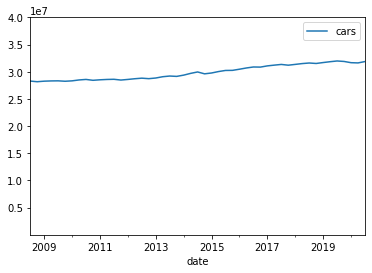

In [56]:
# total_cars.head()
total_cars.plot(ylim=(9, 4e7))

Now take the average miles per year

In [59]:
#ICE miles travelled over time

# Research shows avg miles travelled should be falling e.g. 
# https://www.bymiles.co.uk/insure/magazine/mot-data-research-and-analysis/
# from there we get avg miles per car:

In [60]:
avg = pd.DataFrame([], columns=['date', 'mileage'])
avg['date'] = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007]
avg['date'] = pd.to_datetime(avg['date'], format='%Y')
avg['mileage'] = [7090, 7059, 7134, 7250, 7334, 7421, 7409, 7467, 7473, 7559, 7524, 7637, 7712]

In [61]:
#resample to get quarterly figures
avg = avg.set_index('date').resample('Q').pad()

In [62]:
# extending forwards flat with covid adjustment
# Assumptions (these are the median values for car travel taken from the 'COVID-19-transport-use-statistics.csv' dataset): 
Q1 = 0.93
Q2 = 0.50
Q3 = 0.89
avg.loc['2019-03-31'] = 7090
avg.loc['2019-06-30'] = 7090
avg.loc['2019-09-30'] = 7090
avg.loc['2019-12-31'] = 7090
avg.loc['2020-03-31'] = 7090 * Q1
avg.loc['2020-06-30'] = 7090 * Q2 
avg.loc['2020-09-30'] = 7090 * Q3

<AxesSubplot:xlabel='date'>

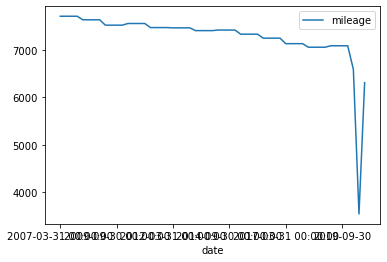

In [63]:
avg.plot()

In [64]:
#merge these
total_m = pd.merge(avg.reset_index(), total_cars.reset_index())

In [65]:
# total miles per year
total_m['miles_quarterly'] = 0.25 * total_m['mileage'] * total_m['cars']

<AxesSubplot:title={'center':'Car miles travelled over time'}, xlabel='date'>

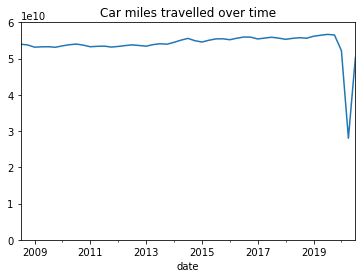

In [66]:
total_m.set_index('date')['miles_quarterly'].plot(title='Car miles travelled over time', ylim=[0,6e10])

Now export that to chart JS

## 2. BEV miles travelled

First, some fundamentals. There have been something like 164,000 BEVs on the roads by the end of Q3 2020". It's taken around 10 years to get there. So assuming a straight line and slightly lower (?) average miles, say 5000. 

We're looking at something like 800m to 1bn+ miles travelled, cumulative.

With the majority of that in the last year or two.

Take BEV sales over time...

In [3]:
# BEV sales
electric = pd.read_csv('ev_dataset.csv')
electric.columns = ['count', 'make', 'model', 'type']

In [4]:
bevs = electric[electric['type'] == 'BEV']

In [5]:
bevs['count'].sum()

33492

In [6]:
#Dictionary of Matched Make:model
cars = {'RENAULT':'ZOE', 'NISSAN':'LEAF', 'NISSAN': 'E-NV200', 'TESLA':'MODEL S', 'BMW': 'I3', 'PEUGEOT':'ION', 'JAGUAR':'I-PACE', 'CHEVROLET': 'VOLT', 'AUDI':'E-TRON', 'MG':'ZS'}

In [7]:
def combine_models(make,model,row):
    """Tries to combine multiple vehicle versions for a specified make or model.
    \\b specifies word boundaries in regex, including start and end of lines.

    E.g. NISSAN, LEAF Model x: (NISSAN, LEAF, row) -> NISSAN, LEAF
    """
    return model if (row['make'] == make) & (bool(re.match(f'\\b{model}\\b', row['model']))) else row['model']

In [8]:
for key, value in cars.items(): 
    bevs['model'] = bevs.apply(lambda x: combine_models(key,value, x), axis = 1)

<ipython-input-8-e3bc3914563e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bevs['model'] = bevs.apply(lambda x: combine_models(key,value, x), axis = 1)


In [9]:
bevs = bevs.groupby(['make', 'model']).sum().reset_index().sort_values('count', ascending=False)

In [10]:
bevs

,make,model,count
42,NISSAN,LEAF,18701
61,RENAULT,ZOE,5437
8,BMW,I3,2167
76,TESLA,MODEL S,1283
52,RENAULT,KANGOO,848
...,...,...,...
29,KIA,NIRO,4
66,SAITING,SCOOTER,3
87,VOLKSWAGEN,E-GOLF,3
74,TESLA,MODEL 3,2


## SMMT top level BEV sales

In [ ]:
bev_sales